In [3]:
from openai import OpenAI
import anthropic
from google import genai
from google.genai import types
import os

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

from collections import Counter
from datetime import datetime, timedelta

%matplotlib inline

## Choose Model

To choose the model, uncomment the row. Comment rows with models that are not used at the moment.

In [71]:
model = "gpt-4o-2024-11-20"
# model = "gpt-4.1"
# model = "o4-mini"
# model = "gpt-5"

In [ ]:
# model = "claude-3-7-sonnet-20250219"
# model = "claude-sonnet-4-20250514"
# model = "claude-opus-4-20250514"

In [ ]:
# model = "deepseek-chat"
# model = "deepseek-reasoner"

In [ ]:
# model = "gemini-2.5-pro-preview-05-06"

In [ ]:
# model = "grok-3-latest"
# model = "grok-3-mini-latest"

To choose whether you want to run prompt for weigths 1 time use avg_weights = False; for 5 times use avg_weigths = True. Uncomment the necessary row, comment the unnecessary ones.

Note: running the prompt for weight assignment in the set of stocks 5 times provides more consistent results. Average weights were used in the research.

In [78]:
avg_weights = True
# avg_weights = False

## Identify sector parameters

To process the sector, uncomment the cell. Comment cells with sectors that are not processed at the moment.

In [ ]:
# sector_name = 'energy'
# sector_name_full = 'Energy'
# sector_ticker = '^GSPE'
# full_ticker = 'SP500-10'

In [ ]:
# sector_name = 'materials'
# sector_name_full = 'Materials'
# sector_ticker = '^SP500-15'
# full_ticker = 'SP500-15'

In [70]:
sector_name = 'industrials'
sector_name_full = 'Industrials'
sector_ticker = '^SP500-20'
full_ticker = 'SP500-20'

In [ ]:
# sector_name = 'consumer_discretionary'
# sector_name_full = 'Consumer Discretionary'
# sector_ticker = '^SP500-25'
# full_ticker = 'SP500-25'

In [ ]:
# sector_name = 'consumer_staples'
# sector_name_full = 'Consumer Staples'
# sector_ticker = '^SP500-30'
# full_ticker = 'SP500-30'

In [ ]:
# sector_name = 'health_care'
# sector_name_full = 'Health Care'
# sector_ticker = '^SP500-35'
# full_ticker = 'SP500-35'

In [ ]:
# sector_name = 'financials'
# sector_name_full = 'Financials'
# sector_ticker = '^SP500-40'
# full_ticker = 'SP500-40'

In [ ]:
# sector_name = 'information_technology'
# sector_name_full = 'Information Technology'
# sector_ticker = '^SP500-45'
# full_ticker = 'SP500-45'

In [ ]:
# sector_name = 'communication_services'
# sector_name_full = 'Communication Services'
# sector_ticker = '^SP500-50'
# full_ticker = 'SP500-50'

In [ ]:
# sector_name = 'utilities'
# sector_name_full = 'Utilities'
# sector_ticker = '^SP500-55'
# full_ticker = 'SP500-55'

In [ ]:
# sector_name = 'real_estate'
# sector_name_full = 'Real Estate'
# sector_ticker = '^SP500-60'
# full_ticker = 'SP500-60'

## Process data

In [72]:
sp500_df = pd.read_csv('SP500.csv')  
companies = sp500_df[sp500_df['GICS Sector'] == sector_name_full]['Symbol']
companies

10      ADP
23     ALLE
27      AME
35      AOS
47     AXON
       ... 
469    VLTO
471    VRSK
478     WAB
487      WM
498     XYL
Name: Symbol, Length: 78, dtype: object

## Load data

In [74]:
## In-sample end date (using 5 years of weekly data prior to end date)
insample_enddate = datetime(2024, 12, 31)

## Out-of-sample period (1 Jan 2025 to 31 March 2025) (using daily data))
outsample_startdate = datetime(2025, 1, 1)
outsample_enddate   = datetime(2025, 3, 31)

insample_startdate = insample_enddate - timedelta(weeks=5*52) # five years prior to Jan 2025

In [75]:
# in-sample
sp500_ins = yf.download(sector_ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)  ## add "auto_adjust = False"
sp500_ins['SP_Return'] = sp500_ins['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_ins.dropna(subset=[('SP_Return', '')], inplace=True) # 520 X 7 (removed first row with NaN in return)
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

# out-of-sample
sp500_outs = yf.download(sector_ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)  ## add auto_adjust = False
sp500_outs['SP_Return'] = sp500_outs['Adj Close'].pct_change()

# Drop NA values in S&P 500 return data
sp500_outs.dropna(subset=[('SP_Return', '')], inplace=True) # removed first row with NaN in return
## change subset from ['SP_Return'] to [('SP_Return', '')] for MultiIndex

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [76]:
insample_data_filename = f'4_returns_insample/SP500_{sector_name}_returns_till_Jan2025.csv'
outsample_data_filename = f'4_returns_outsample/SP500_{sector_name}_returns_since_Jan2025.csv'

In [77]:
if os.path.isfile(insample_data_filename):
    print("Reading data from file", insample_data_filename)
    df_returns = pd.read_csv(insample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returns = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=insample_startdate, end=insample_enddate, interval='1wk', auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()

            # removing first row because first return will be Nan
            df_temp = df_temp.iloc[1:]

            df_temp = df_temp[df_temp.index.isin(sp500_ins.index)]

            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returns[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returns = pd.DataFrame(returns)
    df_returns.to_csv(insample_data_filename)

Reading data from file 4_returns_insample/SP500_consumer_staples_returns_till_Jan2025.csv


In [78]:
# show insample_data_file
df_returns

,ADM,BF.B,BG,CAG,CHD,CL,CLX,COST,CPB,DG,...,PG,PM,SJM,STZ,SYY,TAP,TGT,TSN,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-13,0.029579,0.051427,0.007187,0.047125,0.027104,0.014682,0.026225,0.025030,0.013387,0.033259,...,0.019682,0.014063,0.019256,0.008334,-0.024729,0.027238,-0.062615,-0.022411,0.003504,-0.012201
2020-01-20,-0.020994,0.014843,-0.031038,-0.031503,-0.009583,-0.012363,0.003678,0.019135,0.016035,-0.023103,...,-0.010047,-0.028639,0.012031,0.008476,-0.002294,-0.007955,-0.022238,-0.043735,-0.043558,-0.005132
2020-01-27,0.010383,-0.057808,-0.034794,0.019826,0.040808,0.055870,-0.006128,-0.016070,-0.008198,-0.006026,...,0.001761,-0.040046,-0.037708,-0.017018,-0.005930,-0.009622,-0.031316,-0.038403,-0.022867,0.001050
2020-02-03,0.021224,0.017150,0.031470,-0.023198,0.003638,0.030496,0.063752,0.026545,0.010126,0.010169,...,0.011716,0.057436,0.044590,0.063940,-0.058193,0.039582,0.043977,-0.027593,0.047001,0.017119
2020-02-10,-0.020564,0.037790,0.002589,0.023161,0.026044,0.008681,-0.008422,0.017062,-0.004910,0.019746,...,0.000476,0.012007,0.016354,0.017420,0.010988,-0.043787,0.008823,0.001992,-0.007325,0.012366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-02,-0.058242,0.055371,-0.063963,-0.011252,-0.026514,-0.024837,-0.001196,0.021330,-0.075108,0.055908,...,-0.030347,-0.018788,-0.011291,-0.008093,0.046946,-0.014986,0.000605,-0.021244,-0.050998,0.034595
2024-12-09,0.019059,0.017927,-0.016071,0.035242,-0.014644,-0.008384,-0.012397,-0.003284,0.006085,-0.056992,...,-0.015879,-0.030178,-0.025159,0.002761,-0.009538,0.006229,0.016089,-0.034483,0.213785,-0.015151
2024-12-16,-0.036450,-0.082259,-0.042952,-0.038652,0.004354,-0.015090,-0.002789,-0.035660,-0.034659,-0.007018,...,-0.017538,-0.018954,-0.032062,-0.050196,-0.037394,-0.028328,-0.022599,-0.040675,-0.080847,-0.019158


In [79]:
if os.path.isfile(outsample_data_filename):
    print("Reading data from file", outsample_data_filename)
    df_returnsOUT = pd.read_csv(outsample_data_filename, index_col=0)
else:
    print("Retrieving data from Yahoo Finance")
    returnsOS = {}

    for ticker in companies:
        ticker_saved = ticker
        if '.' in ticker: ticker = ticker.replace('.', '-')
        
        try:
            df_temp = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, auto_adjust = False)

            df_temp['Return'] = df_temp['Adj Close'].pct_change()
            
            # removing first row because first return will be NaN
            df_temp = df_temp.iloc[1:]            

            df_temp = df_temp[df_temp.index.isin(sp500_outs.index)]

            # If not all dates in S&P 500 data are present in stock data, skip this stock
            if not sp500_outs.index.isin(df_temp.index).all():
                print(f'Skipping {ticker} due to mismatch in trading dates.')
                continue

            # If there are still NaN values in stock returns, skip this stock
            if df_temp['Return'].isna().any():
                print(f'Skipping {ticker} due to missing returns.')
                continue

            returnsOS[ticker_saved] = df_temp['Return']

        except Exception as e:
            print(f'Failed to download {ticker} due to error: {e}')

    df_returnsOUT = pd.DataFrame(returnsOS)
    df_returnsOUT.to_csv(outsample_data_filename)

Reading data from file 4_returns_outsample/SP500_consumer_staples_returns_since_Jan2025.csv


In [80]:
df_returnsOUT

,ADM,BF.B,BG,CAG,CHD,CL,CLX,COST,CPB,DG,...,PG,PM,SJM,STZ,SYY,TAP,TGT,TSN,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2025-01-03,-0.003385,-0.025013,-0.003739,-0.000723,0.007704,-0.004417,0.006550,0.007441,-0.006900,-0.012693,...,-0.005121,0.007597,0.001437,-0.002921,0.003059,-0.033741,-0.010205,0.000516,0.033732,0.008667
2025-01-06,-0.008392,0.016276,0.009058,-0.027486,-0.028383,-0.028952,-0.032537,0.006688,-0.029708,0.015803,...,-0.027433,-0.008359,-0.021250,0.004551,-0.009147,0.012484,0.025775,-0.023720,-0.003158,0.007160
2025-01-07,-0.004030,-0.016558,-0.002180,-0.009669,0.011114,-0.001713,0.013389,-0.001452,-0.013580,-0.014483,...,0.004359,0.003306,-0.015482,-0.019827,-0.002542,-0.013760,-0.000287,-0.021479,0.021119,-0.006781
2025-01-08,0.008295,-0.006624,-0.005526,-0.001127,-0.002237,0.000801,0.005823,0.006512,-0.018023,-0.034380,...,0.004960,0.003789,-0.018982,0.003524,0.004024,0.007248,-0.007397,-0.002159,-0.046536,0.010902
2025-01-10,0.025080,-0.059183,0.049625,-0.024812,-0.011212,-0.012577,-0.019050,0.010320,-0.037981,-0.003630,...,-0.021838,-0.038651,-0.042967,-0.170877,-0.016834,-0.056665,0.024598,-0.021457,0.275488,0.013072
2025-01-13,0.020160,0.018015,0.009480,0.012722,0.014198,0.008569,-0.000635,-0.013064,0.023317,0.003223,...,0.001766,0.003415,0.012587,0.022551,0.001631,0.026125,-0.020124,0.025060,0.011905,-0.015806
2025-01-14,-0.017843,-0.000870,-0.004635,-0.008375,0.023527,0.006544,0.009907,-0.008078,0.004920,-0.030870,...,0.005666,0.007826,-0.002545,-0.019956,0.003120,0.007062,-0.016574,-0.003056,0.028571,-0.008085
2025-01-15,-0.000977,-0.021777,-0.014337,-0.020729,-0.017477,0.002167,-0.004590,0.006836,-0.003092,-0.011675,...,-0.000563,0.000338,-0.013640,-0.008123,0.000811,0.005167,-0.014216,0.005409,0.023693,0.006058
2025-01-16,-0.002542,0.011576,-0.012929,0.010976,0.027359,0.007967,0.013708,-0.004061,0.014732,0.010063,...,0.005324,0.010885,0.020096,0.021304,-0.010541,0.009363,-0.009515,0.004663,0.031923,-0.000438


In [81]:
index_tickers = ["^GSPC", "^DJI", "^IXIC", sector_ticker]

index_data_outs = pd.DataFrame()

# Download historical data for each index for out-of-sample period
for ticker in index_tickers:
    index_df = yf.download(ticker, start=outsample_startdate, end=outsample_enddate, interval='1d', auto_adjust = False)  ##add "auto_adjust = False"
    index_df['Index_Return'] = index_df['Adj Close'].pct_change()
    index_df.dropna(subset=[('Index_Return','')], inplace=True)
    index_data_outs[ticker] = index_df['Index_Return']

index_data_outs.index = pd.to_datetime(index_data_outs.index)

valid_index_tickers_outs = []

for ticker in index_tickers:
    # Check if the ticker has continuous data in out-of-sample period
    if ticker in index_data_outs.columns and index_data_outs[ticker].notna().all():
        valid_index_tickers_outs.append(ticker)


index_tickers = valid_index_tickers_outs

print("Valid Index Tickers in Out-of-Sample Period")
print(valid_index_tickers_outs)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Valid Index Tickers in Out-of-Sample Period
['^GSPC', '^DJI', '^IXIC', '^SP500-30']


## LLM API

### 1) ChatGPT API

In [73]:
# gpt models
with open('api_key/openai_api_key.txt', 'r', encoding='utf-8') as f:
    API_KEY = f.readline()
os.environ['OPENAI_API_KEY'] =API_KEY
client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY']
) 

In [74]:
# OpenAI API parameters
max_tokens = 1024
n = 1
stop = None
temperature = 0.5

In [75]:
default_params = {
    "max_tokens": max_tokens,
    "temperature": temperature,
}

In [76]:
def generate_stocks_by_sector(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path = f'cached/gpt/5_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            if model == "gpt-5":
                response1 = client.chat.completions.create(
                    model=model,
                    messages=[
                    {"role": "developer", "content": "You are a helpful  assistant."},
                    {"role": "user", "content": prompt1},
                    ],
                    #max_completion_tokens=max_tokens,
                    n=n,
                    #temperature=temperature,
                    stop=stop,
                )

                coutput1 = response1.choices[0].message.content

            else:
                response1 = client.chat.completions.create(
                    model=model,
                    messages=[
                    {"role": "system", "content": "You are a helpful  assistant."},
                    {"role": "user", "content": prompt1},
                    ],
                    n=n,
                    stop=stop,
                    **(default_params if model != "o4-mini" else {})
                )

                coutput1 = response1.choices[0].message.content

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            if model == "gpt-5":
                response2 = client.chat.completions.create(
                    model=model,
                    messages=[
                    {"role": "developer", "content": "You are a helpful  assistant."},
                    {"role": "user", "content": prompt2},
                    ],
                    #max_completion_tokens=max_tokens,
                    n=n,
                    #temperature=temperature,
                    stop=stop,
                )

                coutput2 = response2.choices[0].message.content
                
            else:
                response2 = client.chat.completions.create(
                    model=model,
                    messages=[
                    {"role": "system", "content": "You are a helpful  assistant."},
                    {"role": "user", "content": prompt2},
                    ],
                    n=n,
                    stop=stop,
                    **(default_params if model != "o4-mini" else {})
                )

                coutput2 = response2.choices[0].message.content

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 20
            if stock in valid_tickers and len(valid_most_common_stocks) < 20:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 20:
            print("There are not enough valid stocks to reach the desired number of 20 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [77]:
generate_stocks_by_sector(sector_name, full_ticker, 10, 20, companies)
print(f'Processed  sector {sector_name}')

Reading from local csv file
{'LMT': 10, 'RTX': 10, 'NOC': 10, 'CAT': 10, 'DE': 10, 'ITW': 8, 'UNP': 10, 'CSX': 6, 'FDX': 8, 'UPS': 6, 'VMC': 2, 'MLM': 1, 'J': 2, 'PWR': 2, 'ETN': 8, 'ROK': 9, 'BA': 10, 'HON': 9, 'MMM': 9, 'GE': 10, 'NSC': 4, 'PCAR': 4, 'ROP': 2, 'PH': 8, 'FTV': 3, 'TDG': 1, 'CMI': 4, 'EMR': 4, 'TXT': 5, 'ROL': 1, 'GD': 1, 'FAST': 1, 'TT': 1, 'FLS': 1, 'NEE': 1, 'FBIN': 1, 'WM': 2, 'IR': 1, 'AME': 1, 'JCI': 1, 'SWK': 1, 'OTIS': 1, 'CARR': 1}
The valid most common stocks are:  ['LMT', 'RTX', 'NOC', 'CAT', 'DE', 'ITW', 'UNP', 'CSX', 'FDX', 'UPS', 'ETN', 'ROK', 'BA', 'HON', 'MMM', 'GE', 'NSC', 'PCAR', 'PH', 'TXT']
Processed  sector industrials


### 2) Claude API

In [579]:
with open('api_key/anthropic_api_key.txt', 'r', encoding='utf-8') as f:
    API_KEY = f.readline()
os.environ['ANTHROPIC_API_KEY'] = API_KEY
client = anthropic.Anthropic(
  api_key=os.environ['ANTHROPIC_API_KEY']
)

In [580]:
# Anthropic API parameters
max_tokens = 1024
temperature = 0.5

In [581]:
def generate_stocks_by_sector_claude(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector (S&P 500 sector index)"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.messages.create(
                model=model,
                system = "You are a helpful  assistant.",
                messages=[
                {"role": "user", "content": prompt1},
                ],
                max_tokens=max_tokens,
                temperature=temperature,
            )

            coutput1 = response1.content[0].text

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.messages.create(
                model=model,
                system = "You are a helpful  assistant.",
                messages=[
                {"role": "user", "content": prompt2},
                ],
                max_tokens=max_tokens,
                temperature=temperature,
            )

            coutput2 = response2.content[0].text

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 20
            if stock in valid_tickers and len(valid_most_common_stocks) < 20:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 20:
            print("There are not enough valid stocks to reach the desired number of 20 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [582]:
generate_stocks_by_sector_claude(sector_name, full_ticker, 10, 20, companies)
print(f'Processed  sector {sector_name}')

Reading from local csv file
{'HON': 10, 'UNP': 10, 'UPS': 4, 'CAT': 10, 'DE': 10, 'LMT': 9, 'GE': 2, 'RTX': 5, 'CARR': 9, 'OTIS': 6, 'GNRC': 7, 'PWR': 6, 'CTAS': 3, 'URI': 2, 'FAST': 4, 'ROK': 9, 'DOV': 7, 'EMR': 10, 'GWW': 1, 'MMM': 8, 'FTV': 8, 'TT': 7, 'XYL': 7, 'AME': 7, 'J': 2, 'NOC': 4, 'PH': 9, 'FDX': 3, 'SWK': 2, 'JCI': 5, 'TXT': 1, 'TDG': 6, 'ITW': 8, 'VRSK': 5, 'CMI': 3, 'PCAR': 1, 'SNA': 1, 'GD': 3, 'IR': 4, 'GGG': 1, 'CSX': 3, 'JBHT': 3, 'RSG': 4, 'WM': 4, 'HEI': 2, 'EXPD': 3, 'CSL': 2, 'MAS': 2, 'LUV': 1, 'HUBB': 1, 'PNR': 1, 'ETN': 2, 'LHX': 1, 'ODFL': 1, 'VRT': 1}
The valid most common stocks are:  ['HON', 'UNP', 'CAT', 'DE', 'LMT', 'CARR', 'OTIS', 'GNRC', 'PWR', 'ROK', 'DOV', 'EMR', 'MMM', 'FTV', 'TT', 'XYL', 'AME', 'PH', 'TDG', 'ITW']
Processed  sector industrials


### 3) Deepseek API

In [491]:
with open('api_key/deepseek_api_key.txt', 'r', encoding='utf-8') as f:
    API_KEY = f.readline()
os.environ['DEEPSEEK_API_KEY'] = API_KEY
client = OpenAI(
  api_key=os.environ['DEEPSEEK_API_KEY'],
  base_url="https://api.deepseek.com"
)

In [492]:
# DEEPSEEK API parameters
max_tokens = 1024
n = 1
stop = None
temperature = 0.5

In [493]:
default_params_ds = {
    "max_tokens": max_tokens,
    "temperature": temperature,
}

In [494]:
def generate_stocks_by_sector_deepseek(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt1},
                ],
                n = n,
                stop = stop,
                **(default_params_ds if model != "deepseek-reasoner" else {})
            )

            coutput1 = response1.choices[0].message.content

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt2},
                ],
                n = n,
                stop = stop,
                **(default_params_ds if model != "deepseek-reasoner" else {})
            )

            coutput2 = response2.choices[0].message.content

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 20
            if stock in valid_tickers and len(valid_most_common_stocks) < 20:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 20:
            print("There are not enough valid stocks to reach the desired number of 20 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [495]:
generate_stocks_by_sector_deepseek(sector_name, full_ticker, 10, 20, companies)
print(f'Processed  sector {sector_name}')

Reading from local csv file
{'PLD': 10, 'AMT': 10, 'EQIX': 10, 'SPG': 10, 'AVB': 10, 'CCI': 10, 'EXR': 10, 'SBAC': 8, 'DLR': 10, 'INVH': 7, 'O': 9, 'WPC': 5, 'VTR': 7, 'ARE': 5, 'PSA': 9, 'IRM': 8, 'REG': 3, 'UDR': 3, 'ESS': 7, 'MAA': 6, 'DRE': 3, 'EQR': 7, 'FRT': 2, 'BXP': 6, 'VNO': 2, 'WELL': 7, 'OHI': 1, 'KIM': 5, 'MAC': 3, 'NNN': 1, 'WY': 2, 'HST': 1, 'EGP': 1, 'VICI': 1, 'CPT': 1}
The valid most common stocks are:  ['PLD', 'AMT', 'EQIX', 'SPG', 'AVB', 'CCI', 'EXR', 'SBAC', 'DLR', 'INVH', 'O', 'VTR', 'ARE', 'PSA', 'IRM', 'ESS', 'MAA', 'EQR', 'BXP', 'WELL']
Processed  sector real_estate


### 4) Gemini API

In [504]:
with open('api_key/gemini_api_key.txt', 'r', encoding='utf-8') as f: ## current one is the test one
    API_KEY = f.readline()
os.environ['GEMINI_API_KEY'] = API_KEY
client = genai.Client(
  api_key=os.environ['GEMINI_API_KEY']
)

In [505]:
# Gemini API parameters 
max_output_tokens = 1024
stop_sequences = None
temperature = 0.5

In [506]:
def generate_stocks_by_sector_gemini(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.models.generate_content(
                model=model,
                contents=[prompt1],
                config=types.GenerateContentConfig(
                    system_instruction="You are a helpful  assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
                )
            )

            coutput1 = response1.text

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.models.generate_content(
                model=model,
                contents=[prompt2],
                config=types.GenerateContentConfig(
                    system_instruction="You are a helpful  assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
                )
            )

            coutput2 = response2.text

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 20
            if stock in valid_tickers and len(valid_most_common_stocks) < 20:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 20:
            print("There are not enough valid stocks to reach the desired number of 20 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [507]:
generate_stocks_by_sector_gemini(sector_name, full_ticker, 10, 20, companies)
print(f'Processed  sector {sector_name}')

Reading from local csv file
{'PLD': 10, 'AMT': 10, 'EQIX': 10, 'PSA': 10, 'O': 8, 'FRT': 5, 'AVB': 10, 'VICI': 9, 'REXR': 10, 'DLR': 10, 'CCI': 10, 'INVH': 8, 'MAA': 6, 'WELL': 10, 'EXR': 9, 'EGP': 5, 'WY': 4, 'SPG': 9, 'BXP': 5, 'VTR': 8, 'EQR': 10, 'ARE': 7, 'AMH': 1, 'IRM': 6, 'REG': 2, 'STAG': 2, 'ELS': 2, 'SUI': 1, 'COLD': 3, 'TRNO': 4, 'LAMR': 1, 'XLRE': 2, 'PEAK': 1, 'WPC': 2, 'FR': 1, 'KIM': 4, 'CUBE': 1, 'HST': 2, 'VNO': 1, 'SBAC': 1}
The valid most common stocks are:  ['PLD', 'AMT', 'EQIX', 'PSA', 'O', 'FRT', 'AVB', 'VICI', 'DLR', 'CCI', 'INVH', 'MAA', 'WELL', 'EXR', 'SPG', 'BXP', 'VTR', 'EQR', 'ARE', 'IRM']
Processed  sector real_estate


### 5) Grok API

In [512]:
with open('api_key/grok_api_key.txt', 'r', encoding='utf-8') as f:  ## this one is the test one
    API_KEY = f.readline()
os.environ['GROK_API_KEY'] = API_KEY
client = OpenAI(
  api_key=os.environ['GROK_API_KEY'],
  base_url="https://api.x.ai/v1",
)

In [513]:
# Grok API parameters
max_tokens = 1024
n = 1
stop = None
temperature = 0.5
reasoning_effort = "high"

In [514]:
default_params_x = {
    "reasoning_effort": reasoning_effort
}

In [515]:
def generate_stocks_by_sector_grok(sector_name, full_ticker, n_count, n_stocks, valid_tickers, recount=False):
    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not recount:
        df = pd.read_csv(csv_path)
        print("Reading from local csv file")

        stock_counter = df.set_index('Stocks')['Count'].to_dict()
        valid_most_common_stocks = df.loc[df['IsValid'] == 1, 'Stocks'].tolist()
        
        print(stock_counter)
        print("The valid most common stocks are: ", valid_most_common_stocks)


    else:    
        prompt1 = f"Using a range of investing principles taken from leading funds, create a theoretical fund comprising of at least {n_stocks} stocks (mention their tickers) from the {full_ticker} {sector_name} sector with the goal to outperform the {full_ticker} {sector_name} sector"

        stock_counter = Counter()

        num_stocks_per_iter = []

        for i in range(n_count):
            response1 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt1},
                ],
                ##max_tokens=max_tokens,
                n=n,
                stop=stop,
                temperature=temperature,
                **(default_params_x if model == "grok-3-mini-latest" else {})
            )

            coutput1 = response1.choices[0].message.content

            prompt2 = 'Extract only the ticker symbols of the stocks comprising the fund from the previous response:- "{input}". In your response to this prompt, list only the ticker symbols separated by spaces.'.format(input=coutput1)

            response2 = client.chat.completions.create(
                model=model,
                messages=[
                {"role": "system", "content": "You are a helpful  assistant."},
                {"role": "user", "content": prompt2},
                ],
                ##max_tokens=max_tokens,
                n=n,
                stop=stop,
                temperature=temperature,
                **(default_params_x if model == "grok-3-mini-latest" else {})
            )

            coutput2 = response2.choices[0].message.content

            stock_tickers = coutput2.split()

            # stock_tickers = [ticker.replace(".", "-") for ticker in stock_tickers]

            stock_tickers = ["META" if ticker == "FB" else ticker for ticker in stock_tickers]
            print(stock_tickers)

            num_stocks_per_iter.append(len(stock_tickers))
            print(num_stocks_per_iter)

            stock_counter.update(stock_tickers)
            print(stock_counter)

        average = round(np.mean(num_stocks_per_iter))

        # Get a list of all the stocks, sorted by frequency (from most to least common)
        sorted_stocks = [stock for stock, _ in stock_counter.most_common()]

        valid_tickers = set(valid_tickers)

        valid_most_common_stocks = []

        for stock in sorted_stocks:
            # If the stock is valid and we still need more stocks to reach the number 20
            if stock in valid_tickers and len(valid_most_common_stocks) < 20:
                valid_most_common_stocks.append(stock)
            elif stock not in valid_tickers:
                print(f"The stock {stock} is not in the valid list of this S&P 500 sector and hence is being discarded.")

        if len(valid_most_common_stocks) < 20:
            print("There are not enough valid stocks to reach the desired number of 20 stocks.")

        print("The valid most common stocks are: ", valid_most_common_stocks)
        
        df = pd.DataFrame.from_dict(stock_counter, orient='index', columns=['Count']).reset_index().rename(columns={'index': 'Stocks'})
        df['IsValid'] = df['Stocks'].apply(lambda x: 1 if x in valid_most_common_stocks else 0)

        df.to_csv(csv_path, index=False)


In [516]:
generate_stocks_by_sector_grok(sector_name, full_ticker, 10, 20, companies)
print(f'Processed  sector {sector_name}')

Reading from local csv file
{'PLD': 10, 'AMT': 9, 'EQIX': 10, 'PSA': 10, 'SPG': 10, 'WELL': 10, 'AVB': 10, 'EQR': 10, 'EXR': 10, 'VTR': 9, 'BXP': 8, 'DLR': 10, 'O': 8, 'KIM': 9, 'FRT': 5, 'REG': 6, 'ESS': 5, 'MAA': 8, 'IRM': 5, 'HST': 6, 'DRE': 2, 'VNO': 4, 'CCI': 4, 'ARE': 2, 'INVH': 3, 'SUI': 2, 'UDR': 1, 'CPT': 2, 'WPC': 1, 'REXR': 2, 'EGP': 2, 'CONE': 1, 'SLG': 1, 'VICI': 1, 'SBAC': 2, 'WY': 1, 'FR': 1}
The valid most common stocks are:  ['PLD', 'AMT', 'EQIX', 'PSA', 'SPG', 'WELL', 'AVB', 'EQR', 'EXR', 'VTR', 'BXP', 'DLR', 'O', 'KIM', 'FRT', 'REG', 'ESS', 'MAA', 'IRM', 'HST']
Processed  sector real_estate


## Count stocks outside of sector

In [43]:
n_stocks = 20

In [65]:
# gpt models
if model == 'gpt-4o-2024-11-20':
    csv_path = f'cached/gpt/4o_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "gpt-4.1":
    csv_path = f'cached/gpt/4.1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "o4-mini":
    csv_path = f'cached/gpt/o4-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "gpt-5":
    csv_path = f'cached/gpt/5_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
# claude model
elif model == "claude-3-7-sonnet-20250219":
    csv_path = f'cached/claude/sonnet-3.7_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "claude-sonnet-4-20250514":
    csv_path = f'cached/claude/sonnet-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "claude-opus-4-20250514":
    csv_path = f'cached/claude/opus-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
# deepseek models
elif model == 'deepseek-chat':
    csv_path = f'cached/ds/dsV3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "deepseek-reasoner":
    csv_path = f'cached/ds/dsR1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
# gemini model
elif model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
# grok models
elif model == 'grok-3-latest':
    csv_path = f'cached/grok/grok3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
elif model == "grok-3-mini-latest":
    csv_path = f'cached/grok/grok3-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'


df_count = pd.read_csv(csv_path)

counter_invalid = 0
for stock in df_count['Stocks']:
    ##print(stock)
    if not (stock in list(companies)):
        counter_invalid += 1
        print(stock)

print(counter_invalid)

AMH
ELS
SUI
PEAK
JLL
LAMR
6


## Count stocks

In [19]:
SMALL2_SIZE = 6
SMALL1_SIZE = 7
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('xtick', labelsize=SMALL_SIZE)

In [25]:
def plot_selected_by_sector(sector):
    # gpt models
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path = f'cached/gpt/5_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # claude model
    elif model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # deepseek models
    elif model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # gemini model
    elif model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # grok models
    elif model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.sort_values(by='IsValid', ascending=False)

    stock_counter = temp_df.set_index('Stocks')['Count'].to_dict()
    print('Number of stocks in the universe before selecting 20: ', len(stock_counter))
    valid_most_common_stocks = temp_df.loc[temp_df['IsValid'] == 1, 'Stocks'].tolist()

    plt.figure(figsize=(10, 6))

    ##modification start
    green_stocks, orange_stocks, gray_stocks = [], [], []
    for ticker, count in stock_counter.items():
        if ticker not in list(companies):
            gray_stocks.append((ticker, count))
        elif ticker in valid_most_common_stocks:
            green_stocks.append((ticker, count))
        else:
            orange_stocks.append((ticker, count))

    green_stocks.sort(key=lambda x: x[1], reverse=True)
    orange_stocks.sort(key=lambda x: x[1], reverse=True)
    gray_stocks.sort(key=lambda x: x[1], reverse=True)

    sorted_stocks = green_stocks + orange_stocks + gray_stocks
    tickers, counts = zip(*sorted_stocks)
    colors = ['green'] * len(green_stocks) + ['orange'] * len(orange_stocks) + ['gray'] * len(gray_stocks)
    ##modification end

    ##tickers, counts = zip(*stock_counter.items())
    ##colors = ['green' if ticker in valid_most_common_stocks else 'orange' for ticker in tickers]

    k_value_case1 = len(valid_most_common_stocks)

    plt.bar(tickers, counts, color=colors)
    plt.xlabel('Stock tickers')
    plt.ylabel('Number of occurrences')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.savefig('GPT_'+str(k_value_case1)+'_instr_universe.eps', format='eps', dpi=1200)
    # plt.savefig('GPT_'+str(k_value_case1)+'_instr_universe.png', format='png', dpi=600)
    plt.title(f'Selected stocks in {sector_name_full} sector ({model})')
    
    green_patch = mpatches.Patch(color='green', label='Valid most frequent stocks')
    orange_patch = mpatches.Patch(color='orange', label='Non-frequent stocks')
    gray_patch = mpatches.Patch(color='gray', label='Stocks outside of sector index')

    plt.legend(handles=[green_patch, orange_patch, gray_patch], 
            loc='upper right')

    plt.show()

    print('Valid most frequent stocks:', len(green_stocks))
    print(f'Processed {sector} sector')

GREY means stocks that are not not valid

Number of stocks in the universe before selecting 20:  37


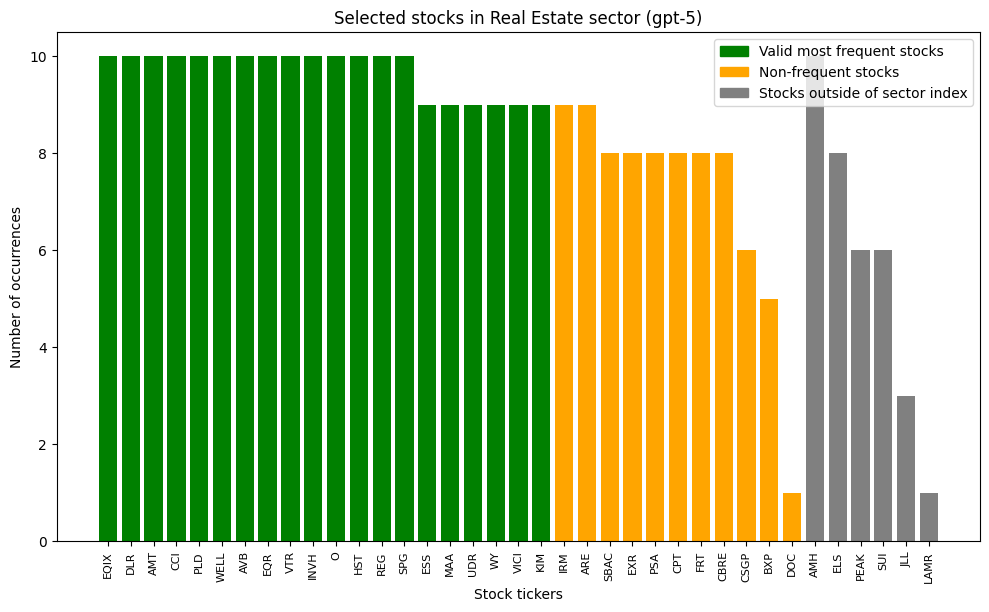

Valid most frequent stocks: 20
Processed real_estate sector


In [66]:
plot_selected_by_sector(sector_name)

## (Draw overlap table)

In [ ]:
def get_csv_path(sector_name, n_stocks):
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # claude model
    elif model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # deepseek models
    elif model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # gemini model
    elif model == 'gemini-2.5-pro-preview-05-06':
        csv_path = f'cached/gemini/gemini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    # grok models
    elif model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    return csv_path

def get_valid_most_stocks(sector_name, n_stocks):     
    csv_path = get_csv_path(sector_name, n_stocks)

    temp_df = pd.read_csv(csv_path)
    temp_df = temp_df.sort_values(by='IsValid', ascending=False)

    stock_counter = temp_df.set_index('Stocks')['Count'].to_dict()
    valid_most_common_stocks = temp_df.loc[temp_df['IsValid'] == 1, 'Stocks'].tolist()
    #print (valid_most_common_stocks)
    return valid_most_common_stocks

In [ ]:
csv_path15 = get_csv_path(sector_name, 15)
csv_path20 = get_csv_path(sector_name, 20)

valid_most_stock15 = get_valid_most_stocks(sector_name, 15)
valid_most_stock20 = get_valid_most_stocks(sector_name, 20)

all_valid_most_stocks = list(set(valid_most_stock15 + valid_most_stock20))

In [ ]:
df15 = pd.read_csv(csv_path15)
df20 = pd.read_csv(csv_path20)

df15 = df15.set_index('Stocks')
df20 = df20.set_index('Stocks')

freq_data = {}

for stock in all_valid_most_stocks:
    freq_15 = df15.loc[stock, 'Count'] if (stock in df15.index and df15.loc[stock, 'IsValid'] == 1) else 0
    freq_20 = df20.loc[stock, 'Count'] if (stock in df20.index and df20.loc[stock, 'IsValid'] == 1) else 0
    
    freq_data[stock] = [freq_15, freq_20]

df = pd.DataFrame(freq_data, index=['15stock_freq', '20stock_freq'])
df_sorted = df.reindex(columns=df.loc['15stock_freq'].sort_values(ascending=False).index)
df_sorted

,ADBE,CRM,MSFT,NVDA,ORCL,AVGO,QCOM,AAPL,CSCO,INTC,TXN,IBM,AMD,MU,NOW,SNPS,AMAT,LRCX,INTU,CDNS
15stock_freq,10,10,10,10,10,10,10,10,10,8,8,6,6,5,4,0,0,0,0,0
20stock_freq,10,10,10,10,9,10,10,10,9,5,8,8,10,10,9,7,7,9,10,6


In [ ]:
with pd.option_context('display.max_columns', None):
    display(df_sorted)

,ADBE,CRM,MSFT,NVDA,ORCL,AVGO,QCOM,AAPL,CSCO,INTC,TXN,IBM,AMD,MU,NOW,SNPS,AMAT,LRCX,INTU,CDNS
15stock_freq,10,10,10,10,10,10,10,10,10,8,8,6,6,5,4,0,0,0,0,0
20stock_freq,10,10,10,10,9,10,10,10,9,5,8,8,10,10,9,7,7,9,10,6


## Weighted portfolio

In [79]:
def convert_reponse4_to_df(coutput4):
    df = pd.DataFrame()
    pairs = coutput4.split(',')
    stocks, weights = [], []

    for pair in pairs:
        stock, weight = pair.split(':')
        stocks.append(stock)
        weights.append(float(weight))

    df = pd.DataFrame({'Stock': stocks, 'Weight': weights})

    if not np.isclose(df['Weight'].sum(), 1):
        df['Weight'] = df['Weight'] / df['Weight'].sum()

    return df

In [80]:
def calculate_avg_weights(responses, stock_list):
    stock_dict = {str(stock): [] for stock in stock_list}

    for response in responses:
        pairs = response.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            stock_dict[str(stock)].append(float(weight))

    averages = {str(stock): sum(weights) / len(weights) for stock, weights in stock_dict.items()}
    print(averages)

    df = pd.DataFrame()
    stocks, weights = [], []

    for stock, weight in averages.items():
        stocks.append(str(stock))
        weights.append(float(weight))

    df = pd.DataFrame({'Stock': stocks, 'Weight': weights})

    if not np.isclose(df['Weight'].sum(), 1):
        df['Weight'] = df['Weight'] / df['Weight'].sum()

    return df

### 1) ChatGPT

In [88]:
def get_weights_by_sector(sector_name, full_ticker):
    if model == 'gpt-4o-2024-11-20':
        csv_path_read = f'cached/gpt/4o_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path_read = f'cached/gpt/4.1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path_read = f'cached/gpt/o4-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path_read = f'cached/gpt/5_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path = f'cached/gpt/5_weights_response/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params if model not in ["o4-mini", "gpt-5"] else {})
        )

        coutput3 = response3.choices[0].message.content

        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'


    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        csv_path = f'cached/gpt/4.1_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path = f'cached/gpt/5_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params if model not in ["o4-mini", "gpt-5"] else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [89]:
# average_weight_calculator
def calculate_weights_by_sector_average(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == 'gpt-4o-2024-11-20':
        csv_path = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'gpt-4.1':
        csv_path = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_tokens, n, stop, temperature = params

    if model == 'gpt-4o-2024-11-20':
        csv_path_read = f'cached/gpt/4o_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == 'gpt-4.1':
        csv_path_read = f'cached/gpt/4.1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == 'o4-mini':
        csv_path_read = f'cached/gpt/o4-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == 'gpt-5':
        csv_path_read = f'cached/gpt/5_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params if model not in ["o4-mini", "gpt-5"] else {})
        )

        coutput3 = response3.choices[0].message.content

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params if model not in ["o4-mini", "gpt-5"] else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == 'gpt-4o-2024-11-20':
            csv_path_write_avg = f'cached/gpt/4o_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-4.1':
            csv_path_write_avg = f'cached/gpt/4.1_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == 'o4-mini':
            csv_path_write_avg = f'cached/gpt/o4-mini_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == 'gpt-5':
            csv_path_write_avg = f'cached/gpt/5_avg_weights_response/responses20_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'gpt-4o-2024-11-20':
        csv_path_write = f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'gpt-4.1':
        csv_path_write = f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "o4-mini":
        csv_path_write = f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "gpt-5":
        csv_path_write = f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv'

    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [90]:
if not avg_weights:
    get_weights_by_sector(sector_name, full_ticker)
else:
    params = (max_tokens, n, stop, temperature)
    calculate_weights_by_sector_average(sector_name, full_ticker, model, params)

Reading from local csv file
   Stock    Weight
0    LMT  0.066691
1    RTX  0.061719
2    NOC  0.070933
3    CAT  0.057796
4     DE  0.057613
5    ITW  0.047487
6    UNP  0.061856
7    CSX  0.042788
8    FDX  0.052231
9    UPS  0.052413
10   ETN  0.057112
11   ROK  0.038318
12    BA  0.061445
13   HON  0.052413
14   MMM  0.033117
15    GE  0.043016
16   NSC  0.042697
17  PCAR  0.033345
18    PH  0.042788
19   TXT  0.024222


### 2) Claude

In [84]:
def get_weights_by_sector_claude(sector_name, full_ticker):
    if model == "claude-3-7-sonnet-20250219":
        csv_path_read = f'cached/claude/sonnet-3.7_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path_read = f'cached/claude/sonnet-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path_read = f'cached/claude/opus-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_weights_response/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.messages.create(
            model=model,
            system = "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
            messages=[
            {"role": "user", "content": prompt3},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput3 = response3.content[0].text
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'


    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.messages.create(
            model=model,
            system = "You are a helpful assistant.",
            messages=[
            {"role": "user", "content": prompt4},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput4 = response4.content[0].text
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [85]:
# average_weight_calculator
def calculate_weights_by_sector_average_claude(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == "claude-3-7-sonnet-20250219":
        csv_path = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_tokens, temperature = params

    if model == "claude-3-7-sonnet-20250219":
        csv_path_read = f'cached/claude/sonnet-3.7_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-sonnet-4-20250514":
        csv_path_read = f'cached/claude/sonnet-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "claude-opus-4-20250514":
        csv_path_read = f'cached/claude/opus-4_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.messages.create(
            model=model,
            system = "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
            messages=[
            {"role": "user", "content": prompt3},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput3 = response3.content[0].text

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.messages.create(
            model=model,
            system = "You are a helpful assistant.",
            messages=[
            {"role": "user", "content": prompt4},
            ],
            max_tokens=max_tokens,
            temperature=temperature,
        )

        coutput4 = response4.content[0].text
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == "claude-3-7-sonnet-20250219":
            csv_path_write_avg = f'cached/claude/sonnet-3.7_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == "claude-sonnet-4-20250514":
            csv_path_write_avg = f'cached/claude/sonnet-4_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == "claude-opus-4-20250514":
            csv_path_write_avg = f'cached/claude/opus-4_avg_weights_response/responses20_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'claude-3-7-sonnet-20250219':
        csv_path_write = f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514':
        csv_path_write = f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514':
        csv_path_write = f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [ ]:
if not avg_weights:
    get_weights_by_sector_claude(sector_name, full_ticker)
else:
    params = (max_tokens, temperature)
    calculate_weights_by_sector_average_claude(sector_name, full_ticker, model, params)

### 3) Deepseek

In [ ]:
def get_weights_by_sector_deepseek(sector_name, full_ticker):
    if model == 'deepseek-chat':
        csv_path_read = f'cached/ds/dsV3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path_read = f'cached/ds/dsR1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_weights_response/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput3 = response3.choices[0].message.content
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'


    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "deepseek-reasoner":
        csv_path = f'cached/ds/dsR1_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [ ]:
# average_weight_calculator
def calculate_weights_by_sector_average_deepseek(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == 'deepseek-chat':
        csv_path = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        csv_path = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_tokens, n, stop, temperature = params

    if model == 'deepseek-chat':
        csv_path_read = f'cached/ds/dsV3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        csv_path_read = f'cached/ds/dsR1_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput3 = response3.choices[0].message.content

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            n=n,
            stop=stop,
            **(default_params_ds if model != "deepseek-reasoner" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == 'deepseek-chat':
            csv_path_write_avg = f'cached/ds/dsV3_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == 'deepseek-reasoner':
            csv_path_write_avg = f'cached/ds/dsR1_avg_weights_response/responses20_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'deepseek-chat':
        csv_path_write = f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        csv_path_write = f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [ ]:
if not avg_weights:
    get_weights_by_sector_deepseek(sector_name, full_ticker)
else:
    params = (max_tokens, n, stop, temperature)
    calculate_weights_by_sector_average_deepseek(sector_name, full_ticker, model, params)

['PLD', 'AMT', 'CCI', 'EQIX', 'O', 'SPG', 'AVB', 'EQR', 'PSA', 'WELL', 'DLR', 'EXR', 'MAA', 'REG', 'ESS', 'SBAC', 'ARE', 'UDR', 'VICI', 'CPT']
calling openai for response to prompt 4 sector real_estate
PLD: 0.12, AMT: 0.09, CCI: 0.08, EQIX: 0.1, DLR: 0.07, SBAC: 0.06, PSA: 0.06, EXR: 0.04, WELL: 0.05, ARE: 0.04, VICI: 0.05, O: 0.03, AVB: 0.04, EQR: 0.04, MAA: 0.03, ESS: 0.02, SPG: 0.05, CPT: 0.01, UDR: 0.01, REG: 0.01


### 4) Gemini

In [ ]:
def get_weights_by_sector_gemini(sector_name, full_ticker):
    csv_path_read = f'cached/gemini/gemini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    csv_path = f'cached/gemini/gemini_weights_response/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.models.generate_content(
            model=model,
            contents=[prompt3],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput3 = response3.text
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'


    csv_path = f'cached/gemini/gemini_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.models.generate_content(
            model=model,
            contents=[prompt4],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput4 = response4.text
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [ ]:
# average_weight_calculator
def calculate_weights_by_sector_average_gemini(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    csv_path = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    max_output_tokens, stop_sequences, temperature = params

    csv_path_read = f'cached/gemini/gemini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.models.generate_content(
            model=model,
            contents=[prompt3],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput3 = response3.text

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.models.generate_content(
            model=model,
            contents=[prompt4],
            config=types.GenerateContentConfig(
                    system_instruction="You are a helpful assistant.",
                    ##max_output_tokens=max_output_tokens,
                    ##stop_sequences=stop_sequences,
                    temperature=temperature
            )
        )

        coutput4 = response4.text
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        csv_path_write_avg = f'cached/gemini/gemini_avg_weights_response/responses20_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    csv_path_write = f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [ ]:
if not avg_weights:
    get_weights_by_sector_gemini(sector_name, full_ticker)
else:
    params = (max_output_tokens, stop_sequences, temperature)
    calculate_weights_by_sector_average_gemini(sector_name, full_ticker, model, params)

['PLD', 'AMT', 'EQIX', 'PSA', 'O', 'FRT', 'AVB', 'VICI', 'DLR', 'CCI', 'INVH', 'MAA', 'WELL', 'EXR', 'SPG', 'BXP', 'VTR', 'EQR', 'ARE', 'IRM']
calling openai for response to prompt 4 sector real_estate
EQIX: 0.1, AMT: 0.1, DLR: 0.08, CCI: 0.07, IRM: 0.03, PLD: 0.12, PSA: 0.06, AVB: 0.05, MAA: 0.05, INVH: 0.04, EXR: 0.04, EQR: 0.02, O: 0.05, VICI: 0.04, ARE: 0.04, WELL: 0.03, VTR: 0.02, FRT: 0.01, BXP: 0.03, SPG: 0.02


### 5) Grok

In [ ]:
def get_weights_by_sector_grok(sector_name, full_ticker):
    if model == 'grok-3-latest':
        csv_path_read = f'cached/grok/grok3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path_read = f'cached/grok/grok3-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)
    prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"
    prompt3

    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_weights_response/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        with open(csv_path, 'r', encoding='utf-8') as f:
            coutput3 = f.read()

    else:
        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput3 = response3.choices[0].message.content
        with open(csv_path, 'w', encoding='utf-8') as f:
            f.write(coutput3)


    prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'


    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == "grok-3-mini-latest":
        csv_path = f'cached/grok/grok3-mini_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path):
        print("Reading from local csv file")
        coutput4 = pd.read_csv(csv_path)

    else:
        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        weights_df = convert_reponse4_to_df(coutput4)

        weights_df.to_csv(csv_path, index=False)

    return coutput4


In [ ]:
# average_weight_calculator
def calculate_weights_by_sector_average_grok(sector_name, full_ticker, model, params, rerun=False):
    # if calculated average weights file already exists
    if model == 'grok-3-latest':
        csv_path = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        csv_path = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'

    if os.path.isfile(csv_path) and not rerun:
        print("Reading from local csv file")
        print(pd.read_csv(csv_path))
        return pd.read_csv(csv_path)

    # otherwise calculate avg weights from scratch
    n, stop, temperature = params

    if model == 'grok-3-latest':
        csv_path_read = f'cached/grok/grok3_sectors/stocks{n_stocks}_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        csv_path_read = f'cached/grok/grok3-mini_sectors/stocks{n_stocks}_auto_{sector_name}.csv'

    sector_df = pd.read_csv(csv_path_read)

    temp_df = sector_df[sector_df['IsValid'] == 1]
    input = temp_df['Stocks'].to_list()
    print(input)

    responses = []

    for i in range(5):
        prompt3 = f"Assume you're designing a theoretical model portfolio from these {full_ticker} {sector_name} stocks: {input}. Provide a hypothetical example of how you might distribute the weightage of these stocks (normalized i.e weights should add up to 1.00) in the portfolio to potentially outperform the {full_ticker} {sector_name} index. Also mention the underlying strategy or logic which you used to assign these weights"

        response3 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant. Your task is to create a hypothetical allocation of weights to the stocks in a theoretical investment fund."},
            {"role": "user", "content": prompt3},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput3 = response3.choices[0].message.content

        prompt4 = f'Extract tickers of stocks and corresponding weights as a single comma "," separated string, with the weights expressed as floats : "{coutput3}". Provide a list of type TICKER: weight, no extra symbols used, and no extra text or explanation. Example output: "AAPL: 0.2, MSFT: 0.3, GOOGL: 0.5'

        print(f'calling openai for response to prompt 4 sector {sector_name}')
        response4 = client.chat.completions.create(
            model=model,
            messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt4},
            ],
            ##max_tokens=max_tokens,
            n=n,
            stop=stop,
            temperature=temperature,
            **(default_params_x if model == "grok-3-mini-latest" else {})
        )

        coutput4 = response4.choices[0].message.content
        print(coutput4.strip('"'))

        if 'Sure' in coutput4:
            coutput4 = coutput4.strip('\n')[1]

        responses.append(coutput4)

        # data_dict = {key.strip(): float(value.strip()) for key, value in (pair.split(":") for pair in coutput4.split(","))}
        data_dict = dict()

        pairs = coutput4.split(',')

        for pair in pairs:
            stock, weight = pair.split(':')

            stock = stock.lstrip()
            if "\"" in stock: stock = stock.strip("\"")
            if "\'" in stock: stock = stock.strip("\'")

            weight = weight.lstrip()
            if "\"" in weight: weight = weight.strip("\"")
            if "\'" in weight: weight = weight.strip("\'")

            data_dict[str(stock).strip()] = float(weight.strip())


        if model == 'grok-3-latest':
            csv_path_write_avg = f'cached/grok/grok3_avg_weights_response/responses20_auto_{sector_name}.csv'
        elif model == 'grok-3-mini-latest':
            csv_path_write_avg = f'cached/grok/grok3-mini_avg_weights_response/responses20_auto_{sector_name}.csv'

        if os.path.isfile(csv_path_write_avg):
            print("Adding weights to file")

            existing_df = pd.read_csv(csv_path_write_avg)
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])

            # check if the 'asset' column in the existing DataFrame matches the keys in the parsed data
            common_assets = set(existing_df['Stock']).intersection(set(data_dict.keys()))

            existing_df[f'Weight_{i}'] = existing_df['Stock'].map(lambda x: data_dict[x] if x in common_assets else None)

            new_assets = set(data_dict.keys()).difference(set(existing_df['Stock']))
            new_df = new_df[new_df['Stock'].isin(new_assets)]
            
            final_df = pd.concat([existing_df, new_df], ignore_index=True)
            final_df.to_csv(csv_path_write_avg, index=False)

        else:
            print("Creating a file to keep weights from responses")
            new_df = pd.DataFrame(list(data_dict.items()), columns=['Stock', f'Weight_{i}'])
            new_df.to_csv(csv_path_write_avg, index=False)


    print("Calculating averages")
    avg_weights_response_df = calculate_avg_weights(responses, input)

    if model == 'grok-3-latest':
        csv_path_write = f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        csv_path_write = f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv'
    
    avg_weights_response_df.to_csv(csv_path_write, index=False)

    return avg_weights_response_df


In [ ]:
if not avg_weights:
    get_weights_by_sector_grok(sector_name, full_ticker)
else:
    params = (n, stop, temperature)
    calculate_weights_by_sector_average_grok(sector_name, full_ticker, model, params)

['AMT', 'PLD', 'EQIX', 'SPG', 'PSA', 'O', 'DLR', 'AVB', 'EQR', 'WELL', 'BXP', 'WY', 'ARE', 'EXR', 'INVH', 'MAA', 'UDR', 'KIM', 'CCI', 'ESS']
calling openai for response to prompt 4 sector real_estate
AMT: 0.07, ARE: 0.04, AVB: 0.05, BXP: 0.03, CCI: 0.06, DLR: 0.09, EQIX: 0.10, EQR: 0.05, ESS: 0.05, EXR: 0.05, INVH: 0.04, KIM: 0.03, MAA: 0.04, O: 0.04, PLD: 0.08, PSA: 0.05, SPG: 0.02, UDR: 0.04, WELL: 0.04, WY: 0.03


## Normalization

In [91]:
def normalise_from_csv(path):
    df_temp = pd.read_csv(path)

    for i in range(5):
        if not np.isclose(df_temp[f'Weight_{i}'].sum(), 1):
            df_temp[f'Weight_{i}'] = df_temp[f'Weight_{i}'] / df_temp[f'Weight_{i}'].sum()
    df_temp.to_csv(path, index=False) ##

    return df_temp

In [92]:
# gpt
if model == 'gpt-4o-2024-11-20':
    csv_path_write_avg = f'cached/gpt/4o_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == "gpt-4.1":
    csv_path_write_avg = f'cached/gpt/4.1_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == "o4-mini":
    csv_path_write_avg = f'cached/gpt/o4-mini_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == "gpt-5":
    csv_path_write_avg = f'cached/gpt/5_avg_weights_response/responses20_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat':
    csv_path_write_avg = f'cached/ds/dsV3_avg_weights_response/responses20_auto_{sector_name}.csv'  
elif model == 'deepseek-reasoner':
    csv_path_write_avg = f'cached/ds/dsR1_avg_weights_response/responses20_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219':
    csv_path_write_avg = f'cached/claude/sonnet-3.7_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514':
    csv_path_write_avg = f'cached/claude/sonnet-4_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514':
    csv_path_write_avg = f'cached/claude/opus-4_avg_weights_response/responses20_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06':
    csv_path_write_avg = f'cached/gemini/gemini_avg_weights_response/responses20_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest':
    csv_path_write_avg = f'cached/grok/grok3_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest':
    csv_path_write_avg = f'cached/grok/grok3-mini_avg_weights_response/responses20_auto_{sector_name}.csv'

normalise_from_csv(csv_path_write_avg)

,Stock,Weight_0,Weight_1,Weight_2,Weight_3,Weight_4
0,LMT,0.066667,0.058824,0.074766,0.069565,0.066667
1,RTX,0.050000,0.050420,0.070093,0.060870,0.061905
2,NOC,0.058333,0.058824,0.070093,0.052174,0.071429
3,CAT,0.075000,0.067227,0.060748,0.086957,0.057143
4,DE,0.066667,0.067227,0.060748,0.078261,0.057143
5,ITW,0.041667,0.042017,0.051402,0.043478,0.047619
6,UNP,0.058333,0.058824,0.056075,0.069565,0.061905
7,CSX,0.041667,0.042017,0.046729,0.034783,0.042857
8,FDX,0.041667,0.050420,0.051402,0.052174,0.052381
9,UPS,0.050000,0.050420,0.051402,0.060870,0.052381


## Weight volatility

In [93]:
# gpt
if model == 'gpt-4o-2024-11-20':
    csv_path_write_avg = f'cached/gpt/4o_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == "gpt-4.1":
    csv_path_write_avg = f'cached/gpt/4.1_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == "o4-mini":
    csv_path_write_avg = f'cached/gpt/o4-mini_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == "gpt-5":
    csv_path_write_avg = f'cached/gpt/5_avg_weights_response/responses20_auto_{sector_name}.csv'
# ds
elif model == 'deepseek-chat':
    csv_path_write_avg = f'cached/ds/dsV3_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'deepseek-reasoner':
    csv_path_write_avg = f'cached/ds/dsR1_avg_weights_response/responses20_auto_{sector_name}.csv'
# claude
elif model == 'claude-3-7-sonnet-20250219':
    csv_path_write_avg = f'cached/claude/sonnet-3.7_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'claude-sonnet-4-20250514':
    csv_path_write_avg = f'cached/claude/sonnet-4_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'claude-opus-4-20250514':
    csv_path_write_avg = f'cached/claude/opus-4_avg_weights_response/responses20_auto_{sector_name}.csv'
# gemini
elif model == 'gemini-2.5-pro-preview-05-06':
    csv_path_write_avg = f'cached/gemini/gemini_avg_weights_response/responses20_auto_{sector_name}.csv'
# grok
elif model == 'grok-3-latest':
    csv_path_write_avg = f'cached/grok/grok3_avg_weights_response/responses20_auto_{sector_name}.csv'
elif model == 'grok-3-mini-latest':
    csv_path_write_avg = f'cached/grok/grok3-mini_avg_weights_response/responses20_auto_{sector_name}.csv'

dfw = pd.read_csv(csv_path_write_avg)

fig = px.box(dfw, x='Stock', y=['Weight_0', 'Weight_1', 'Weight_2', 'Weight_3', 'Weight_4'], points="all",
             title=f"Weight volatility for {full_ticker} {sector_name} sector ({model} model)",
             labels={'variable': 'Columns', 'value': 'Weight'})

fig.update_layout(
    height=600, 
    width=900,
    xaxis_title='Stock in the portfolio',
    yaxis_title='Weight of the stock in the portfolio',
    plot_bgcolor='white',
    xaxis=dict(        
        linecolor='black',
        linewidth=1.5
    ),
    yaxis=dict(
        gridcolor='lightgray',     
        linecolor='black', 
        linewidth=1.5
    )
)
fig.show()


In [180]:
# not avg_weights
#gpt
if model == 'gpt-4o-2024-11-20' and not avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/4o_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'gpt-4.1' and not avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/4.1_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'o4-mini' and not avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/o4-mini_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'gpt-5' and not avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/5_weights_assigned/responses20_auto_{sector_name}.csv')
# ds
elif model == 'deepseek-chat' and not avg_weights:
    df_20 = pd.read_csv(f'cached/ds/dsV3_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'deepseek-reasoner' and not avg_weights:
    df_20 = pd.read_csv(f'cached/ds/dsR1_weights_assigned/responses20_auto_{sector_name}.csv')
# claude
elif model == 'claude-3-7-sonnet-20250219' and not avg_weights:
    df_20 = pd.read_csv(f'cached/claude/sonnet-3.7_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'claude-sonnet-4-20250514' and not avg_weights:
    df_20 = pd.read_csv(f'cached/claude/sonnet-4_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'claude-opus-4-20250514' and not avg_weights:
    df_20 = pd.read_csv(f'cached/claude/opus-4_weights_assigned/responses20_auto_{sector_name}.csv')
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and not avg_weights:
    df_20 = pd.read_csv(f'cached/gemini/gemini_weights_assigned/responses20_auto_{sector_name}.csv')
# grok
elif model == 'grok-3-latest' and not avg_weights:
    df_20 = pd.read_csv(f'cached/grok/grok3_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'grok-3-mini-latest' and not avg_weights:
    df_20 = pd.read_csv(f'cached/grok/grok3-mini_weights_assigned/responses20_auto_{sector_name}.csv')

# average weights
# gpt
elif model == 'gpt-4o-2024-11-20' and avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/4o_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'gpt-4.1' and avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/4.1_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'o4-mini' and avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/o4-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'gpt-5' and avg_weights:
    df_20 = pd.read_csv(f'cached/gpt/5_avg_weights_assigned/responses20_auto_{sector_name}.csv')
# ds
elif model == 'deepseek-chat' and avg_weights:
    df_20 = pd.read_csv(f'cached/ds/dsV3_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'deepseek-reasoner' and avg_weights:
    df_20 = pd.read_csv(f'cached/ds/dsR1_avg_weights_assigned/responses20_auto_{sector_name}.csv')
# claude
elif model == 'claude-3-7-sonnet-20250219' and avg_weights:
    df_20 = pd.read_csv(f'cached/claude/sonnet-3.7_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'claude-sonnet-4-20250514' and avg_weights:
    df_20 = pd.read_csv(f'cached/claude/sonnet-4_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'claude-opus-4-20250514' and avg_weights:
    df_20 = pd.read_csv(f'cached/claude/opus-4_avg_weights_assigned/responses20_auto_{sector_name}.csv')
# gemini
elif model == 'gemini-2.5-pro-preview-05-06' and avg_weights:
    df_20 = pd.read_csv(f'cached/gemini/gemini_avg_weights_assigned/responses20_auto_{sector_name}.csv')
# grok
elif model == 'grok-3-latest' and avg_weights:
    df_20 = pd.read_csv(f'cached/grok/grok3_avg_weights_assigned/responses20_auto_{sector_name}.csv')
elif model == 'grok-3-mini-latest' and avg_weights:
    df_20 = pd.read_csv(f'cached/grok/grok3-mini_avg_weights_assigned/responses20_auto_{sector_name}.csv')

df_20

,Stock,Weight
0,XOM,0.080
1,CVX,0.080
2,COP,0.060
3,EOG,0.060
4,OXY,0.050
5,FANG,0.050
6,DVN,0.035
7,APA,0.025
8,CTRA,0.050
9,HES,0.070


In [181]:
sum(df_20['Weight'])

1.0000000000000004

## Weight Volatility across LLMs and sectors

Calculating weight volatility metrics...

Weight Volatility Matrix:
                   Energy  Materials  Industrials  Consumer Discretionary  \
GPT-4o             0.0057     0.0062       0.0052                  0.0051   
GPT-4.1            0.0038     0.0054       0.0050                  0.0067   
O4-Mini            0.0149     0.0120       0.0098                  0.0123   
GPT-5              0.0061     0.0061       0.0057                  0.0064   
DeepSeek-Chat      0.0063     0.0049       0.0028                  0.0083   
DeepSeek-Reasoner  0.0115     0.0095       0.0101                  0.0079   
Claude-3.7-Sonnet  0.0043     0.0044       0.0036                  0.0044   
Claude-4-Sonnet    0.0125     0.0096       0.0028                  0.0050   
Claude-4-Opus      0.0107     0.0107       0.0052                  0.0064   
Gemini-2.5-Pro     0.0080     0.0118       0.0040                  0.0092   
Grok-3             0.0028     0.0034       0.0033                  0.0040   
Grok-3-M

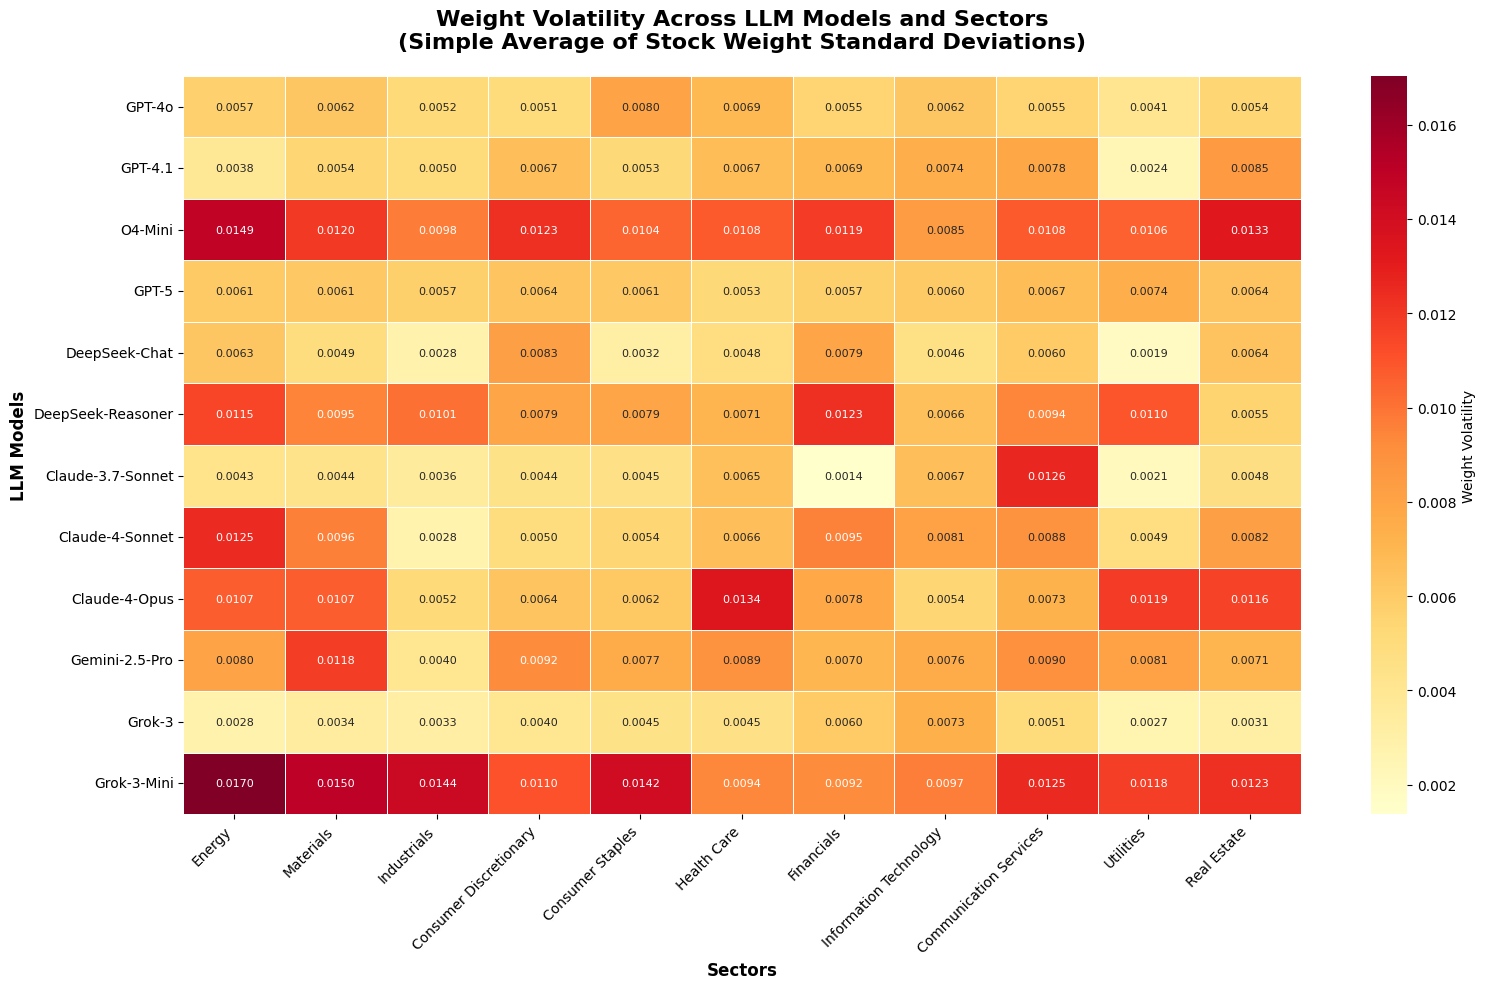

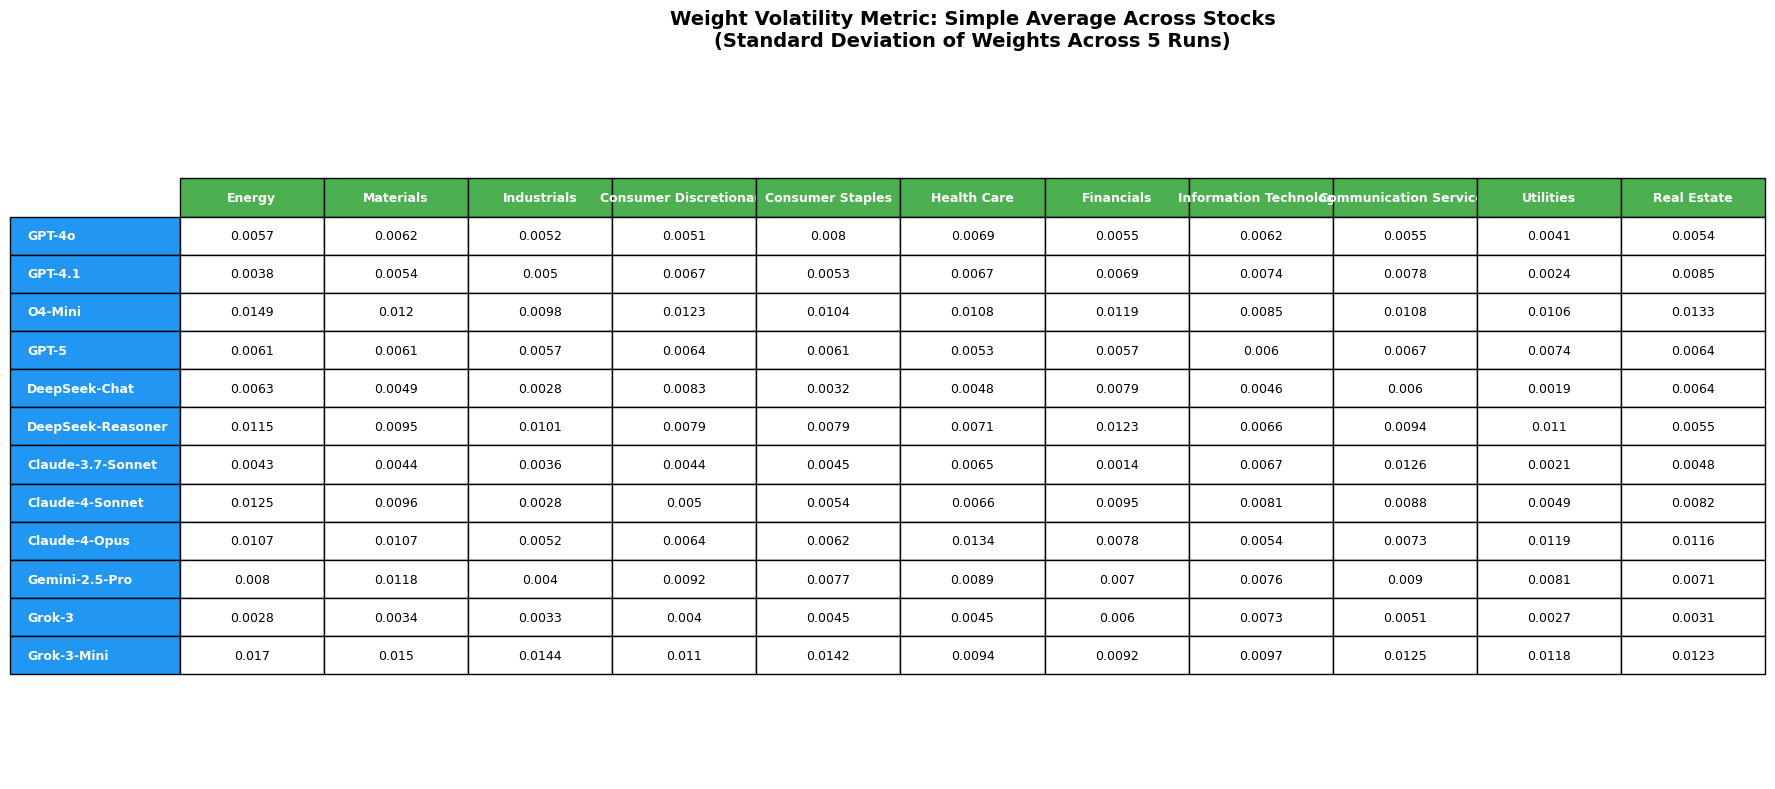

In [5]:
def get_csv_path(model, sector_name):
    """Get the CSV file path for a given model and sector"""
    if model == 'gpt-4o-2024-11-20':
        return f'cached/gpt/4o_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "gpt-4.1":
        return f'cached/gpt/4.1_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "o4-mini":
        return f'cached/gpt/o4-mini_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == "gpt-5":
        return f'cached/gpt/5_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'deepseek-chat':
        return f'cached/ds/dsV3_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'deepseek-reasoner':
        return f'cached/ds/dsR1_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'claude-3-7-sonnet-20250219':
        return f'cached/claude/sonnet-3.7_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'claude-sonnet-4-20250514':
        return f'cached/claude/sonnet-4_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'claude-opus-4-20250514':
        return f'cached/claude/opus-4_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'gemini-2.5-pro-preview-05-06':
        return f'cached/gemini/gemini_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'grok-3-latest':
        return f'cached/grok/grok3_avg_weights_response/responses20_auto_{sector_name}.csv'
    elif model == 'grok-3-mini-latest':
        return f'cached/grok/grok3-mini_avg_weights_response/responses20_auto_{sector_name}.csv'
    else:
        raise ValueError(f"Unknown model: {model}")

def calculate_weight_volatility(csv_path):
    """Calculate the simple average weight volatility for a given CSV file"""
    try:
        df = pd.read_csv(csv_path)
        
        # Get weight columns (Weight_0 to Weight_4)
        weight_cols = [col for col in df.columns if col.startswith('Weight_')]
        
        # Calculate standard deviation for each stock across the 5 runs
        stock_volatilities = []
        for idx, row in df.iterrows():
            weights = row[weight_cols].values
            # Remove NaN values
            weights = weights[~pd.isna(weights)]
            if len(weights) > 1:
                volatility = np.std(weights)
                stock_volatilities.append(volatility)
        
        # Return simple average of all stock volatilities
        if stock_volatilities:
            return np.mean(stock_volatilities)
        else:
            return np.nan
            
    except FileNotFoundError:
        print(f"File not found: {csv_path}")
        return np.nan
    except Exception as e:
        print(f"Error processing {csv_path}: {e}")
        return np.nan

def create_weight_volatility_matrix():
    """Create the weight volatility matrix for all models and sectors"""
    
    # Define models and sectors
    models = [
        'gpt-4o-2024-11-20', 'gpt-4.1', 'o4-mini', 'gpt-5', 
        'deepseek-chat', 'deepseek-reasoner',
        'claude-3-7-sonnet-20250219', 'claude-sonnet-4-20250514', 'claude-opus-4-20250514',
        'gemini-2.5-pro-preview-05-06',
        'grok-3-latest', 'grok-3-mini-latest'
    ]
    
    sectors = ['energy', 'materials', 'industrials', 'consumer_discretionary',
               'consumer_staples', 'health_care', 'financials', 'information_technology',
               'communication_services', 'utilities', 'real_estate']
    
    # Create model display names for better visualization
    model_display_names = {
        'gpt-4o-2024-11-20': 'GPT-4o',
        'gpt-4.1': 'GPT-4.1',
        'o4-mini': 'O4-Mini',
        'gpt-5': 'GPT-5',
        'deepseek-chat': 'DeepSeek-Chat',
        'deepseek-reasoner': 'DeepSeek-Reasoner',
        'claude-3-7-sonnet-20250219': 'Claude-3.7-Sonnet',
        'claude-sonnet-4-20250514': 'Claude-4-Sonnet',
        'claude-opus-4-20250514': 'Claude-4-Opus',
        'gemini-2.5-pro-preview-05-06': 'Gemini-2.5-Pro',
        'grok-3-latest': 'Grok-3',
        'grok-3-mini-latest': 'Grok-3-Mini'
    }
    
    # Initialize results matrix
    results = []
    
    # Calculate volatility for each model-sector combination
    for model in models:
        model_results = []
        for sector in sectors:
            csv_path = get_csv_path(model, sector)
            volatility = calculate_weight_volatility(csv_path)
            model_results.append(volatility)
        results.append(model_results)
    
    # Create DataFrame
    df_results = pd.DataFrame(results, 
                             index=[model_display_names[m] for m in models],
                             columns=[s.replace('_', ' ').title() for s in sectors])
    
    return df_results

def plot_weight_volatility_heatmap(df_results):
    """Create a heatmap visualization of weight volatilities"""
    
    # Set up the plot
    plt.figure(figsize=(16, 10))
    
    # Create heatmap
    sns.heatmap(df_results, 
                annot=True, 
                fmt='.4f', 
                cmap='YlOrRd',
                cbar_kws={'label': 'Weight Volatility'},
                linewidths=0.5,
                annot_kws={'size': 8})
    
    plt.title('Weight Volatility Across LLM Models and Sectors\n(Simple Average of Stock Weight Standard Deviations)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Sectors', fontsize=12, fontweight='bold')
    plt.ylabel('LLM Models', fontsize=12, fontweight='bold')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

def plot_weight_volatility_table(df_results):
    """Create a table visualization of weight volatilities"""
    
    fig, ax = plt.subplots(figsize=(18, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=df_results.round(4).values,
                    rowLabels=df_results.index,
                    colLabels=df_results.columns,
                    cellLoc='center',
                    loc='center')
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2)
    
    # Color the header
    for i in range(len(df_results.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color the row labels
    for i in range(len(df_results.index)):
        table[(i+1, -1)].set_facecolor('#2196F3')
        table[(i+1, -1)].set_text_props(weight='bold', color='white')
    
    plt.title('Weight Volatility Metric: Simple Average Across Stocks\n(Standard Deviation of Weights Across 5 Runs)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

def analyze_weight_volatility():
    """Main function to analyze weight volatility"""
    
    print("Calculating weight volatility metrics...")
    df_results = create_weight_volatility_matrix()
    
    print("\nWeight Volatility Matrix:")
    print(df_results.round(4))
    
    print("\nSummary Statistics:")
    print(f"Overall mean volatility: {df_results.values.flatten().mean():.4f}")
    print(f"Overall std volatility: {df_results.values.flatten().std():.4f}")
    
    print("\nMean volatility by model:")
    model_means = df_results.mean(axis=1).sort_values(ascending=False)
    for model, mean_vol in model_means.items():
        print(f"{model}: {mean_vol:.4f}")
    
    print("\nMean volatility by sector:")
    sector_means = df_results.mean(axis=0).sort_values(ascending=False)
    for sector, mean_vol in sector_means.items():
        print(f"{sector}: {mean_vol:.4f}")
    
    # Create visualizations
    plot_weight_volatility_heatmap(df_results)
    plot_weight_volatility_table(df_results)
    
    return df_results

# Run the analysis
if __name__ == "__main__":
    results_df = analyze_weight_volatility()

In [6]:
results_df.round(4)

styled_df = results_df.round(4).style.background_gradient(
    cmap='YlOrRd', 
    axis=None
).format('{:.4f}')

display(styled_df)  

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
GPT-4o,0.0057,0.0062,0.0052,0.0051,0.0080,0.0069,0.0055,0.0062,0.0055,0.0041,0.0054
GPT-4.1,0.0038,0.0054,0.0050,0.0067,0.0053,0.0067,0.0069,0.0074,0.0078,0.0024,0.0085
O4-Mini,0.0149,0.0120,0.0098,0.0123,0.0104,0.0108,0.0119,0.0085,0.0108,0.0106,0.0133
GPT-5,0.0061,0.0061,0.0057,0.0064,0.0061,0.0053,0.0057,0.0060,0.0067,0.0074,0.0064
DeepSeek-Chat,0.0063,0.0049,0.0028,0.0083,0.0032,0.0048,0.0079,0.0046,0.0060,0.0019,0.0064
DeepSeek-Reasoner,0.0115,0.0095,0.0101,0.0079,0.0079,0.0071,0.0123,0.0066,0.0094,0.0110,0.0055
Claude-3.7-Sonnet,0.0043,0.0044,0.0036,0.0044,0.0045,0.0065,0.0014,0.0067,0.0126,0.0021,0.0048
Claude-4-Sonnet,0.0125,0.0096,0.0028,0.0050,0.0054,0.0066,0.0095,0.0081,0.0088,0.0049,0.0082
Claude-4-Opus,0.0107,0.0107,0.0052,0.0064,0.0062,0.0134,0.0078,0.0054,0.0073,0.0119,0.0116
Gemini-2.5-Pro,0.0080,0.0118,0.0040,0.0092,0.0077,0.0089,0.0070,0.0076,0.0090,0.0081,0.0071
